In [ ]:

"""
Created on Tue Nov 12 00:29:38 2024

@author: Daniel Thomas
"""
# Load the data

import pandas as pd
import warnings
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

data = pd.read_csv("Train_data.csv")

# Define function to fit various PDFs and calculate MSE with error handling
def fit_distributions(data_column, distributions):
    mse_results = {}
    x = np.linspace(min(data_column), max(data_column), 100)

    # Loop through each distribution and fit the data
    for dist_name in distributions:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)  # Suppress warnings
                dist = getattr(stats, dist_name)
                params = dist.fit(data_column)
                
                # Check if parameters are valid (non-NaN and finite)
                if not all(np.isfinite(params)):
                    raise ValueError(f"Invalid parameters {params} for distribution {dist_name}")
                
                # Calculate the PDF and handle any errors
                try:
                    pdf_fitted = dist.pdf(x, *params)
                    if not np.all(np.isfinite(pdf_fitted)):  # Ensure PDF values are finite
                        raise ValueError(f"Invalid PDF values for distribution {dist_name}")

                    # Calculate the Mean Squared Error, ensuring no NaN or inf values
                    mse = np.mean((pdf_fitted - np.histogram(data_column, bins=100, density=True)[0]) ** 2)
                    mse_results[dist_name] = mse
                except (ValueError, TypeError) as e:
                    print(f"Skipping {dist_name} due to PDF calculation error: {e}")
                
        except (ValueError, RuntimeError, OverflowError, TypeError) as e:
            print(f"Skipping {dist_name} due to fitting error: {e}")

    # Find distribution with the lowest MSE if any were successful
    if mse_results:
        best_fit = min(mse_results, key=mse_results.get)
        return best_fit, mse_results[best_fit]
    else:
        return None, None  # Return None if all distributions failed

# Expanded list of distributions to test
distributions = [
    'norm', 'uniform', 'expon', 'pareto',  'cauchy', 'triang',
    'weibull_min', 'weibull_max', 'gamma', 'beta', 'chi2', 'fisk', 
    't', 'genextreme', 'gumbel_r', 'gumbel_l', 'laplace', 'rayleigh',
    'invgauss', 'halfnorm', 'exponpow', 'exponnorm', 
    'invweibull', 'nakagami', 'johnsonsu', 'genlogistic', 'dweibull'
]
# Select numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.difference(['class'])
results = []

# Loop through each numerical column and compute best fits
for column in numerical_columns:
    col_data = data[column]
    col_data_normal = col_data[data['class'] == 'normal']
    col_data_anomaly = col_data[data['class'] == 'anomaly']

    # Fit distributions for overall, normal, and anomaly cases
    overall_best_fit, overall_mse = fit_distributions(col_data, distributions)
    normal_best_fit, normal_mse = fit_distributions(col_data_normal, distributions)
    anomaly_best_fit, anomaly_mse = fit_distributions(col_data_anomaly, distributions)

    # Append results
    results.append({
        'Column': column,
        'Overall Best Fit': overall_best_fit,
        'Overall MSE': overall_mse,
        'Normal Best Fit': normal_best_fit,
        'Normal MSE': normal_mse,
        'Anomaly Best Fit': anomaly_best_fit,
        'Anomaly MSE': anomaly_mse
    })

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Function to plot the PDF fit for a given data column
def plot_pdf_fit(column_name, overall_fit, normal_fit, anomaly_fit, overall_mse, normal_mse, anomaly_mse):
    col_data = data[column_name]
    col_data_normal = col_data[data['class'] == 'normal']
    col_data_anomaly = col_data[data['class'] == 'anomaly']

    # Create histogram and setup x-range
    x = np.linspace(min(col_data), max(col_data), 100)

    # Plot histogram and overall best-fit PDF
    plt.figure(figsize=(10, 6))
    plt.hist(col_data, bins=30, density=True, alpha=0.5, color='grey', label='Data Histogram')

    # Fit overall PDF
    dist_overall = getattr(stats, overall_fit)
    params_overall = dist_overall.fit(col_data)
    pdf_overall = dist_overall.pdf(x, *params_overall)
    plt.plot(x, pdf_overall, label=f'Overall Best Fit ({overall_fit}), MSE={overall_mse:.2e}', linewidth=2)

    # Fit normal PDF
    dist_normal = getattr(stats, normal_fit)
    params_normal = dist_normal.fit(col_data_normal)
    pdf_normal = dist_normal.pdf(x, *params_normal)
    plt.plot(x, pdf_normal, label=f'Normal Best Fit ({normal_fit}), MSE={normal_mse:.2e}', linestyle='--', linewidth=2)

    # Fit anomaly PDF
    dist_anomaly = getattr(stats, anomaly_fit)
    params_anomaly = dist_anomaly.fit(col_data_anomaly)
    pdf_anomaly = dist_anomaly.pdf(x, *params_anomaly)
    plt.plot(x, pdf_anomaly, label=f'Anomaly Best Fit ({anomaly_fit}), MSE={anomaly_mse:.2e}', linestyle=':', linewidth=2)

    # Adding plot details
    plt.title(f'PDF Fit for {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Loop through each numerical column and plot the PDF fits
for _, row in results_df.iterrows():
    plot_pdf_fit(
        row['Column'],
        overall_fit=row['Overall Best Fit'],
        normal_fit=row['Normal Best Fit'],
        anomaly_fit=row['Anomaly Best Fit'],
        overall_mse=row['Overall MSE'],
        normal_mse=row['Normal MSE'],
        anomaly_mse=row['Anomaly MSE']
    )


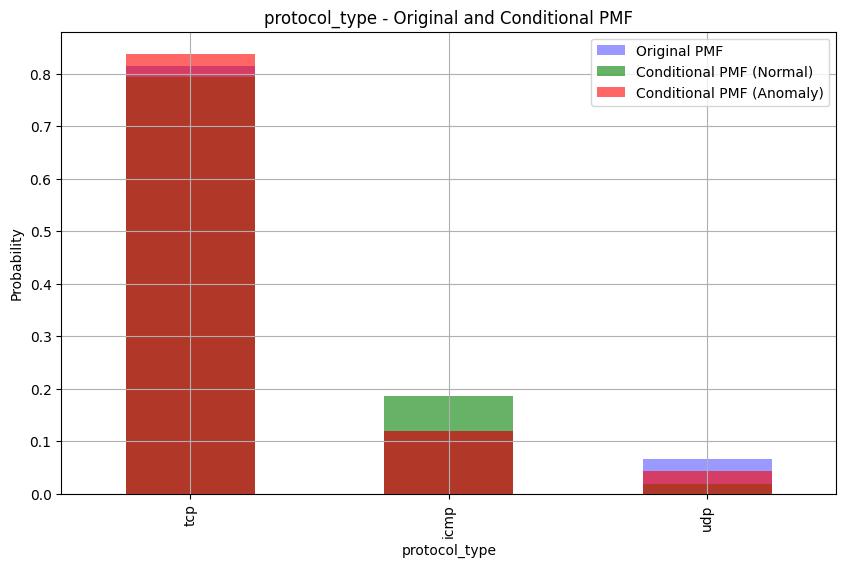

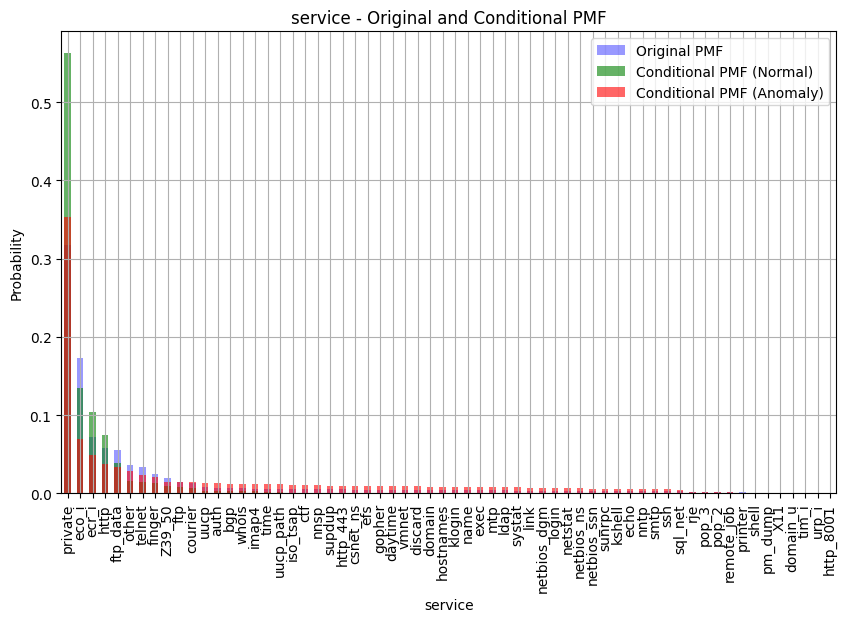

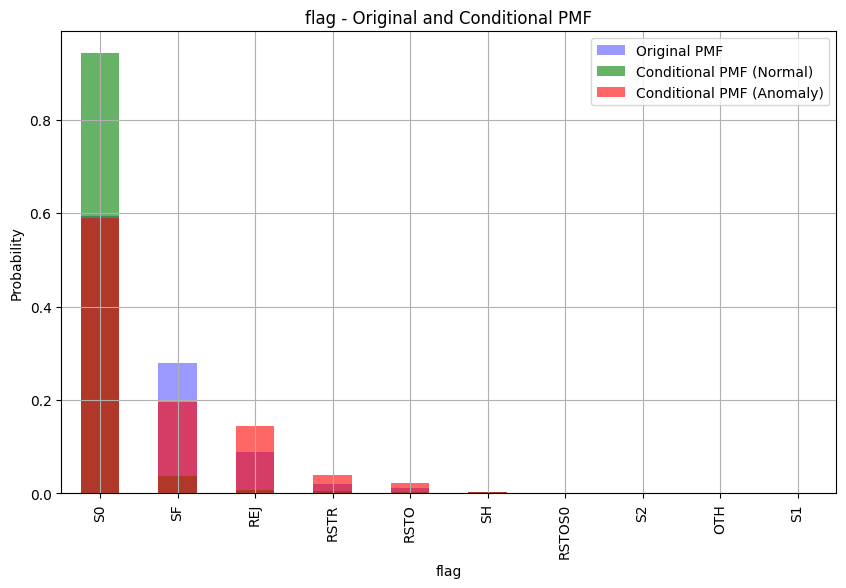

In [ ]:
import matplotlib.pyplot as plt

def plot_pmf_conditional_for_columns(data):
    for column in data.columns:
        if column == 'class':  
            continue

        # Check if there's data in the column
        if data[column].notna().sum() == 0:
            continue  # Skip column if all values are NaN

        # Check if the column is categorical
        if data[column].dtype == 'object' or data[column].dtype.name == 'category':
            # Calculate PMFs
            pmf = data[column].value_counts(normalize=True)
            normal_rows = data[data['class'] == "normal"]
            anomaly_rows = data[data['class'] == "anomaly"]
            conditional_pmf_normal = normal_rows[column].value_counts(normalize=True) if not normal_rows.empty else None
            conditional_pmf_anomaly = anomaly_rows[column].value_counts(normalize=True) if not anomaly_rows.empty else None

            # Skip the plot if all PMFs are empty
            if pmf.empty and (conditional_pmf_normal is None or conditional_pmf_normal.empty) and (conditional_pmf_anomaly is None or conditional_pmf_anomaly.empty):
                continue

            # Plotting
            plt.figure(figsize=(10, 6))  
            if not pmf.empty:
                pmf.plot(kind='bar', color='blue', alpha=0.4, label='Original PMF')
            if conditional_pmf_normal is not None and not conditional_pmf_normal.empty:
                conditional_pmf_normal.plot(kind='bar', color='green', alpha=0.6, label='Conditional PMF (Normal)')
            if conditional_pmf_anomaly is not None and not conditional_pmf_anomaly.empty:
                conditional_pmf_anomaly.plot(kind='bar', color='red', alpha=0.6, label='Conditional PMF (Anomaly)')

            # Adding plot details
            plt.title(f'{column} - Original and Conditional PMF')
            plt.xlabel(column)
            plt.ylabel('Probability')
            plt.legend()
            plt.grid()
            plt.show()

# Run the function
plot_pmf_conditional_for_columns(data)



In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

file_path = r'C:\Users\Daniel Thomas\Downloads\Train_data.csv'
data = pd.read_csv(file_path)

# Function to summarize best fit results for numerical columns
def summarize_numerical_results(data):
    distributions = [
    'norm', 'uniform', 'expon', 'pareto',  'cauchy', 'triang',
    'weibull_min', 'weibull_max', 'gamma', 'beta', 'chi2', 'fisk', 
    't', 'genextreme', 'gumbel_r', 'gumbel_l', 'laplace', 'rayleigh',
    'invgauss', 'halfnorm', 'exponpow', 'exponnorm', 
    'invweibull', 'nakagami', 'johnsonsu', 'genlogistic', 'dweibull'
]
    numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.difference(['class'])
    summary = []

    for column in numerical_columns:
        col_data = data[column]
        fit_results = fit_distributions(col_data, distributions)
        best_fit_name = min(fit_results, key=lambda k: fit_results[k][0])
        best_fit_params = fit_results[best_fit_name][1]
        summary.append({
            'Column': column,
            'Best Fit Distribution': best_fit_name,
            'Parameters': best_fit_params
        })

    return summary

# Function to calculate PMF for categorical columns
def calculate_pmf(data):
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns
    pmf_data = {}

    for column in categorical_columns:
        counts = data[column].value_counts()
        pmf = counts / counts.sum()  # Normalize to get PMF
        pmf_data[column] = pmf.to_dict()  # Store as dictionary for easy reference

    return pmf_data

# Get the summary of best fit distributions for numerical columns
numerical_results_summary = summarize_numerical_results(data)
numerical_results_df = pd.DataFrame(numerical_results_summary)
print("Numerical Results Summary:")
print(numerical_results_df)

# Get the PMF data for categorical columns
categorical_pmf_data = calculate_pmf(data)
print("\nCategorical PMF Data:")
for column, pmf in categorical_pmf_data.items():
    print(f"Column: {column}")
    for category, probability in pmf.items():
        print(f"  {category}: {probability:.4f}")



C:\Users\Daniel Thomas\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\Daniel Thomas\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_continuous_distns.py:723: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
C:\Users\Daniel Thomas\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_continuous_distns.py:8753: RuntimeWarning: overflow encountered in divide
  s3 = (1/xm).sum()
C:\Users\Daniel Thomas\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_distn_infrastructure.py:1988: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\Daniel Thomas\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_continuous_distns.py:7868: Runti

Could not fit gamma to is_host_login: Optimization converged to parameters that are outside the range allowed by the distribution.
Could not fit gumbel_r to is_host_login: loop of ufunc does not support argument 0 of type float which has no callable exp method
Could not fit gumbel_l to is_host_login: loop of ufunc does not support argument 0 of type float which has no callable exp method
Could not fit rayleigh to is_host_login: Solver for the MLE equations failed to converge: The function value at x=-5e-324 is NaN; solver cannot continue.


C:\Users\Daniel Thomas\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_continuous_distns.py:8754: RuntimeWarning: invalid value encountered in scalar multiply
  return s1 - s2/(2*len(data))*s3
C:\Users\Daniel Thomas\AppData\Roaming\Python\Python312\site-packages\scipy\optimize\_optimize.py:836: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Could not fit beta to logged_in: Optimization converged to parameters that are outside the range allowed by the distribution.
Could not fit gamma to num_outbound_cmds: Optimization converged to parameters that are outside the range allowed by the distribution.
Could not fit gumbel_r to num_outbound_cmds: loop of ufunc does not support argument 0 of type float which has no callable exp method
Could not fit gumbel_l to num_outbound_cmds: loop of ufunc does not support argument 0 of type float which has no callable exp method
Could not fit rayleigh to num_outbound_cmds: Solver for the MLE equations failed to converge: The function value at x=-5e-324 is NaN; solver cannot continue.
Numerical Results Summary:
                         Column Best Fit Distribution  \
0                         count                cauchy   
1                 diff_srv_rate             exponnorm   
2                     dst_bytes              halfnorm   
3                dst_host_count           weibull_max   
4